# Visualizing Neural Network Features

## 1
We've spent a good deal of energy looking at the patterns of weights learned by classifiers such as multilayer perceptrons and such.  This is very interesting, however it doesn't provide a means of interrogating what's happening beyond the very first layer (where the weights are amenable to reshaping into an image).  This is especially acute as neural networks become *deep* and have more exotic architectures.  Here, we will interrogate the "nodes" (abstractly in this case) of an enormous convolutional neural network, to figure out what they are looking for.  In so doing, we will see that deep neural networks represent and recognize objects by constructing a hierarchy of visual concepts that are sequentially combined to form higher-level representations.   

## 2 VGG
For real industrial scale applications, many interesting CNNs already exist and are available *pre-trained*, and we can query their behavior.  One notable example is the neural network VGG16, which has the following architecture:
<img src="vgg.png" />
This is a so-called *deep network* because it has many layers.  It is also interesting because it doesn't do much fancy stuff (take advanced ML or Computer Vision if you want to know about fancy stuff), and the features that it extracts end up being relatively comprehensible.  Note that VGG was trained on (a subset of) the [ImageNet](http://www.image-net.org/) dataset, which contains 15M labelled images and more than 20000 classes.  VGG was trained on more than a million of these and can recognize 1k different classes.  It's very large: 138M parameters and was trained for three weeks on an array of four Titan XP GPUs.  

We have straightforward access to it via pytorch, specifically the torchvision package.  It might take you a bit of time to download the weights the first time.  

In [2]:
import torchvision.models as tvm
model = tvm.vgg16(pretrained=True).eval()

Now that we have VGG, we'd like to create a mechanism that determines what its nodes are looking for.  Stated more precisely, one way to solve this problem is to explicitly construct an image that maximizes a given node's activation: what picture makes that node light up?  The following class solves that problem, by computing gradients of a specified nodal activation with respect to an (initially random) input image, and adjusting that image so as the activation is maximized.  There are also a few tricks invoked to make these images more compelling: a bit of regularization, some upscaling and restarting from upscaled images, etc.    

In [3]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter

from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

from skimage.transform import resize

class FeatureVisualizer(object):
    """Class for visualizing features in the pretrained pytorch VGG model"""
    def __init__(self,model):
        """Pass in the correct model"""
        self.model = model  
           
    def create_feature_maximizer(self,layer_index,kernel_index,n_steps=10,gaussian_blur=0.1,imsize=64,upscaling_steps=10,upscaling_factor=1.2):
        """Finds an image that maximizes the activations induced by a given kernel
        Arguments:
           layer_index: the index of the layer in question
           kernel_index: the index of the kernel in that layer
           n_steps: number of optimization steps to take
           gaussian_blur: how much to blur the resulting image to minimize high frequency noise
           imsize: how big an image to make
        Outputs: 
           img: the image that maximizes the given activation
        """
        
        # Instantiate a random image of the appropriate size and convert it to a variable
        img = torch.from_numpy(np.uint8(np.random.uniform(-125, 125, (3,imsize, imsize)))/255)
        img = img.to(torch.float32).detach().unsqueeze(0)
        img = img.clone().detach().requires_grad_(True)


        for j in range(upscaling_steps):
            
            sz = int(upscaling_factor**j * imsize)  # calculate new image size
            img = resize(img.detach().numpy().squeeze().transpose(1,2,0), (sz, sz)).transpose(2,0,1)  # scale image up
            img = torch.from_numpy(img)
            img = img.to(torch.float32).detach().unsqueeze(0)
            img = img.clone().detach().requires_grad_(True)    
            print(img.shape)
            
            # Instantiate an optimizer, with the pixel values of the input image as the variable to be optimized
            optimizer = torch.optim.Adam([img], lr=1e-1,weight_decay=1e-6)
            
            # Optimize
            for i in range(n_steps):
                # Zero the gradient buffer
                optimizer.zero_grad()
            
                # Create a data structure to store intermediate network outputs
                outputs = []
                def hook_fn(module, input, output):
                    outputs.append(output)
            
                # Create a function that will store a given layer's output
                hook = model.features[layer_index].register_forward_hook(hook_fn)
            
                # Run the model on the current image value
                output = model(img)
            
                # Define the loss using the layer output
                loss = -outputs[0][0,kernel_index].mean()
            
                # Print some stats
                print("Negative Mean activation for layer:",layer_index,", kernel index", kernel_index,": ",loss.item())
            
                # Compute the gradient
                loss.backward()
            
                # Update the pixel values
                optimizer.step()
            
                # Destroy the intermediate output function
                hook.remove()
            
        # Convert img to w x h x channel, convert to numpy, remove batch dimension
        img = np.moveaxis(img.detach().numpy().squeeze(),0,2)
        
        img_new = img - img.mean(axis=(0,1))# + np.array([0.485, 0.456, 0.406])
        img_new /= img_new.std(axis=(0,1))
        img_new *= np.array([0.229, 0.224, 0.225])
        img_new += np.array([0.485, 0.456, 0.406])
              
        return img_new
    
    def get_mean_layer_activations(self,image_path,layer_index,imsize=224):
        """Computes the mean activations of a layer for a given image
        Arguments:
          image_path: the path to the image we want to run the network on
          layer_index: the layer that we want to compute the mean activations for
        Outputs:
          mean_layer_activations: the mean of each feature map in a layer after being evaluated on an image
        """
        # Load and normalize image to format expected by VGG network
        loader = transforms.Compose([transforms.Resize(imsize),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
        
        # Define data structure to hold intermediate network output
        outputs= []
        def hook_fn(module, input, output):
            outputs.append(output)
        
        # Define a function to load the image
        def image_loader(image_name):
            """load image, returns cuda tensor"""
            image = Image.open(image_name)
            image = loader(image).float()
            image = Variable(image, requires_grad=True)
            image = image.unsqueeze(0)
            return image

        # Load the image
        img = image_loader(image_path)

        # Run the model and save intermediate output
        hook = self.model.features[layer_index].register_forward_hook(hook_fn)
        output = self.model(img)
        hook.remove()
        mean_layer_activations = np.mean(outputs[0].detach().cpu().numpy().squeeze(),axis=(1,2))
        return mean_layer_activations


Now, we need to determine what layer to query.  We can do this by looking at the model architecture:

In [4]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Let's see what type of image the first kernel in the first convolutional layer (after applying relu) is looking for.  This is Layer 1, kernel 0.

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
import matplotlib.pyplot as plt

layer = 23
kernel = 0
fv = FeatureVisualizer(model)
img = fv.create_feature_maximizer(layer,kernel,n_steps=20,imsize=32,upscaling_steps=10,upscaling_factor=1.3)


torch.Size([1, 3, 32, 32])
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean activation for layer: 23 , kernel index 0 :  -0.0
Negative Mean

Negative Mean activation for layer: 23 , kernel index 0 :  -204.30540466308594
Negative Mean activation for layer: 23 , kernel index 0 :  -213.46815490722656
Negative Mean activation for layer: 23 , kernel index 0 :  -222.6284637451172
Negative Mean activation for layer: 23 , kernel index 0 :  -231.7158203125
Negative Mean activation for layer: 23 , kernel index 0 :  -240.84205627441406
Negative Mean activation for layer: 23 , kernel index 0 :  -249.94981384277344
Negative Mean activation for layer: 23 , kernel index 0 :  -258.947998046875
Negative Mean activation for layer: 23 , kernel index 0 :  -267.85107421875
Negative Mean activation for layer: 23 , kernel index 0 :  -276.7002258300781
Negative Mean activation for layer: 23 , kernel index 0 :  -285.5182189941406
torch.Size([1, 3, 154, 154])
Negative Mean activation for layer: 23 , kernel index 0 :  -85.03087615966797
Negative Mean activation for layer: 23 , kernel index 0 :  -110.19444274902344
Negative Mean activation for layer: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


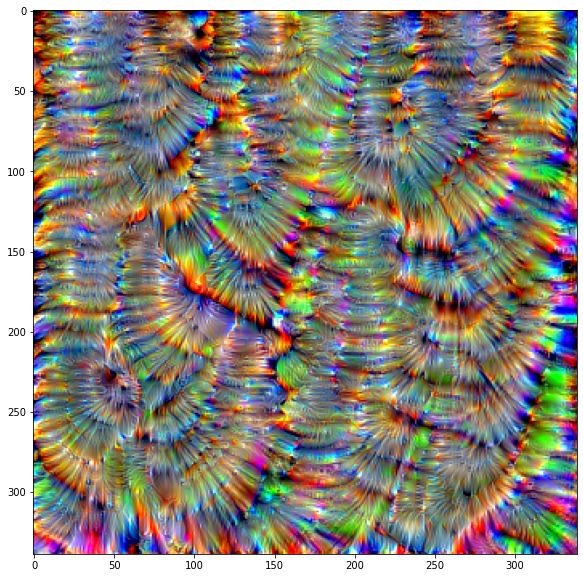

In [10]:
plt.imshow(img)

## Examining features at different layers
Produce images like the ones above for several other kernels in this CNN layer.  What type of features does this kernel seem to be focusing on.  Do the same for different layers.  What can you say about the complexity of the features being detected at deeper levels of the neural network? (you will find that this procedure is a bit unstable and may not work for layers very late in the network, especially the last one).  

## Targeted extraction
We can also examine what the network is focusing when extracting features *for a specific image*.  Download your own image of a common object (a cat, or a truck, or something simple), and use the *get_mean_layer_activations* method in the class given above to get the mean activations for a given layer as a function of the kernel index.  Identify which kernel for a given layer is most strongly activated by your particular image.  Then, generate the image that maximizes the activation for that layer and kernel.  What feature of your chosen image is the network looking at?

In [ ]:
#e.g.
mean_layer_activations = fv.get_mean_layer_activations('cat.jpg',15)
plt.plot(mean_layer_activations)
print(np.argmax(mean_layer_activations))